In [1]:
import numpy as np
import traj_opt 
jsonfilename = r"./210905154645_TEST-1_MOBILERADAR5_last_live_new.json"
import json
with open(jsonfilename,"r") as fp:
    data = json.load(fp)
    # print(data)

uv_dist = data["uv_undist"]
xyz = np.array(data["xyz_ccs"])
in_time = []
pos = []
for it in data["Payload"]["BallTrajectory"]:
    in_time.append(it['Time'])
    pos.append(it['Pos'])

# print(xyz)

# print(pos)
# print(xyz.shape)


In [2]:
def trajectory_poly_fit(position_list, time_list):
    # trajectory_points = trajectory['Payload']['BallTrajectory']
    # time_list =np.asarray([t['Time'] for t in trajectory_points])
    # position_list = np.asarray([t['Pos'] for t in trajectory_points])
    poly_x = np.polynomial.polynomial.polyfit(time_list, position_list[:, 0], 6)  # don't use np.polyfit, it failed
    poly_y = np.polynomial.polynomial.polyfit(time_list, position_list[:, 1], 6)
    poly_z = np.polynomial.polynomial.polyfit(time_list, position_list[:, 2], 6)
    x_fit = np.polynomial.Polynomial(poly_x)
    y_fit = np.polynomial.Polynomial(poly_y)
    z_fit = np.polynomial.Polynomial(poly_z)
    print("first trajectory point: {}".format(position_list[0, :]))
    print("first fitting point: {}".format([x_fit(time_list[0]), y_fit(time_list[0]), z_fit(time_list[0])]))
    return poly_x, poly_y, poly_z

In [3]:
pos = np.array(pos)
in_time = np.array(in_time)
idx = 5
fit_time = in_time[idx:]
fit_pos = xyz[idx:,:]
# print(fit_pos)
# print(fit_time)

poly_x, poly_y, poly_z = trajectory_poly_fit(fit_pos, fit_time)

first trajectory point: [ 2.28717324 -7.11437001 40.2434477 ]
first fitting point: [2.330644548266946, -6.9683918204095425, 40.28306939323465]


In [4]:
# Polynomial coefficients ordered from low to high
# ts = 0.5
# tt = np.array([1,ts, ts**2, ts**3, ts**4, ts**5,ts**6])
# print(tt.shape)
# print(poly_x.shape)
# print([np.dot(tt, poly_x),np.dot(tt, poly_y),np.dot(tt, poly_z)])

ts = fit_time[0]
## get starting point, velocity and acceleration
def get_starting_pva(poly_x, poly_y, poly_z, ts):
    tp = np.array([1,ts, ts**2, ts**3, ts**4, ts**5,ts**6])
    tv = np.array([0, 1, 2*ts, 3*ts**2, 4*ts**3, 5*ts**4, 6*ts**5])
    ta = np.array([0, 0, 2, 6*ts, 12*ts**2, 20*ts**3, 30*ts**4])

    px=np.dot(tp, poly_x);py=np.dot(tp, poly_y);pz=np.dot(tp, poly_z)
    vx=np.dot(tv, poly_x);vy=np.dot(tv, poly_y);vz=np.dot(tv, poly_z)
    ax=np.dot(ta, poly_x);ay=np.dot(ta, poly_y);az=np.dot(ta, poly_z)

    return (px, vx, ax, py, vy, ay, pz, vz, az)

In [5]:
px, vx, ax, py, vy, ay, pz, vz, az=get_starting_pva(poly_x, poly_y, poly_z, ts)
print([px,py,pz])

[2.330644548266946, -6.968391820409543, 40.283069393234655]


In [6]:
num_seg = 1
num_pts = num_seg + 1
x0 = np.zeros((9*num_pts,1))
tau = 1
l = 0
mu = 1
t_s = np.arange(0,num_pts)*tau

scale = 1 / fit_time[0]
print(scale)

pav_end = [px, vx / scale, ax / (scale**2), py, vy / scale, ay / (scale**2), pz, vz / scale, az / (scale**2)]

pva = np.full((len(x0),),np.math.nan)
# print(pva.shape)
for i in range(9, pva.shape[0]):
    pva[i] = pav_end[i-9]
print(pva)


p_cons = xyz[0:idx,:]
pf = p_cons.flatten()
# print(p_cons)
# p = p.reshape((p.size,1))
print(pf)
t_cons = in_time[0:idx] * scale
print(t_cons)
tols = np.linspace(0.5, 0.3, len(t_cons))
tols = np.ones((3,1))@tols.reshape((1,len(t_cons)))
print(tols.T.flatten())

2.0
[        nan         nan         nan         nan         nan         nan
         nan         nan         nan  2.33064455  0.98768864 -0.53290942
 -6.96839182 -9.11774942  2.15510873 40.28306939 32.36697204 -4.05956102]
[ 0.55575288  1.16274413  4.96533883  0.98155654 -0.52477368 12.46723692
  1.36554295 -2.19888651 19.73984998  1.70763304 -3.85901656 26.77319502
  2.01820995 -5.48753747 33.60827817]
[0.  0.2 0.4 0.6 0.8]
[0.5  0.5  0.5  0.45 0.45 0.45 0.4  0.4  0.4  0.35 0.35 0.35 0.3  0.3
 0.3 ]


In [7]:
%reload_ext autoreload
%autoreload 2
import traj_opt 
A, b = traj_opt.eq_constraint_end_pva(x0, pva)
# print(A)
# print(b)
P, q = traj_opt.objective_endpoint(x0, tau, l, mu)
G1, h1 = traj_opt.ineq_pos_constraint_end(x0, pf, t_cons, t_s, tol=tols.T.flatten())
# print(h1)
G2, h2 = traj_opt.naive_uv_constraint(x0, uv_dist, tol=0.001)
# print(G2)
if G1 is not None and G2 is not None:
    G = np.vstack((G1,G2))
    h = np.hstack((h1,h2))
elif G1 is not None:
    G = G1
    h = h1
elif G2 is not None:
    G = G2
    h = h2

# t_in = warp_real_time_to_virtual_time(t, t_cons)
# print(t_in)
# t_in = np.array([0,0.5,1,1.3,2])
# print(P.shape)
# print(h)

# lb = np.ones((len(x0),1))*-200
# ub = np.ones((len(x0),1))*200
# lb[]


x = traj_opt.optimize(P, q, G, h, A, b)
print(x)

num_cons: 5
[0.5  0.5  0.5  0.45 0.45 0.45 0.4  0.4  0.4  0.35 0.35 0.35 0.3  0.3
 0.3 ]
[ 0.5708072   2.24845661 -0.58721149  1.54139344 -8.80069802 -5.61769128
  5.46533884 36.27221758 -1.07169424  2.33897126  0.9543818  -0.53290942
 -6.96839182 -8.98305512  2.15510873 40.34650003 32.36697204 -4.05956102]


Populating the interactive namespace from numpy and matplotlib


C:\Users\xiahaa\AppData\Local\Continuum\anaconda3\envs\dev36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['poly']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


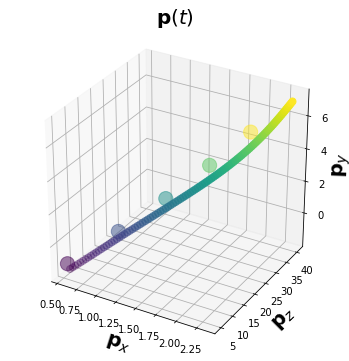

In [8]:
poly = traj_opt.get_polynomial_coefficients(x)
xyz_s, t = traj_opt.get_traj_pts(poly, num_pts_per_seg = 100)
# print(xyz_s)
%pylab inline
from pylab import *

# p = np.array([[0,0,0],[1,4,2]]).flatten()
# p = p.reshape((2,-1))
# print(p)
import mpl_toolkits.mplot3d
figsize(6,6);
fig = plt.figure(); ax = fig.add_subplot(111, projection="3d");
ax.scatter(xyz_s[:,0], xyz_s[:,2], -xyz_s[:,1], c=t, s=50);
ax.scatter(p_cons[:,0], p_cons[:,2], -p_cons[:,1], c=t_cons, s=200, alpha=0.5);
title("$\\mathbf{p}(t)$\n", fontsize=20);
ax.set_zlabel("$\\mathbf{p}_y$", fontsize=20);
xlabel("$\\mathbf{p}_x$", fontsize=20); ylabel("$\\mathbf{p}_z$", fontsize=20);

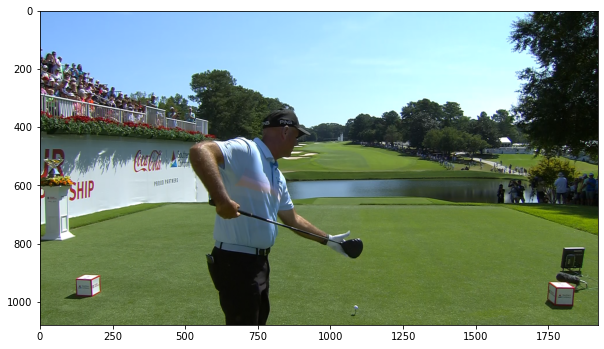

In [9]:
import cv2 as cv
img = cv.imread(r'./210905154645_TEST-1_MOBILERADAR5_Broadcast.png',1)
plt.figure(figsize=(10,10))
img[:,:,[0,2]] = img[:,:,[2,0]]
plt.imshow(img)
plt.show()

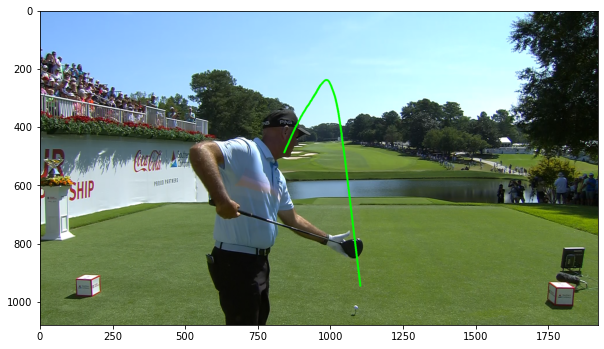

In [10]:
import GeometryUtils
landing_height=0
points_uv = []
xyz_tpr_sequence=[[-0.05778752388168463,0.008088496508494887,0.002898126162545146,-0.05410133340616103,1.5994299397961187,
                  -0.002201014807195206]]
cam_f=np.array([1580.8590649, 1580.8590649])
cam_c=[925.2106820540487, 575.8055319374084]
cam_dis=[0.0, 0.0, 0.0, 0.0]
total_points = len(pos)
for index, xyz in enumerate(pos):
    if index > total_points / 2 and xyz[1] < landing_height:  # ingore the points have y < 0 on the second half of the trajectory
                continue
    points_uv.append(GeometryUtils.point_transform_cv_project(xyz, xyz_tpr_sequence, cam_f, cam_c, cam_dis)[0])

poly_points = np.array(points_uv).reshape((-1, 1, 2)).astype(np.int)
if True:
    image = cv.polylines(img, [poly_points], isClosed=False, color=(0, 255, 0), thickness=6)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

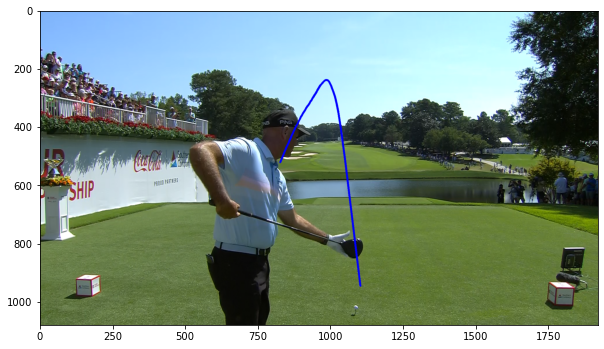

In [78]:
landing_height=0
points_uv = []
cam_f=np.array([1580.8590649, 1580.8590649])
cam_c=[925.2106820540487, 575.8055319374084]
cam_dis=[0.0, 0.0, 0.0, 0.0]

cam_K = np.array([[cam_f[0], 0, cam_c[0]],[0, cam_f[1], cam_c[1]],[0, 0, 1]])
cam_K_distortion = np.array(cam_dis)
zero = np.array([0.0, 0.0, 0.0])

point_cam_xyz_cv = np.array(data["xyz_ccs"])

point_cam_uv = cv.projectPoints(point_cam_xyz_cv.reshape(-1, 3), zero, zero, cam_K, cam_K_distortion)[0]
poly_points = point_cam_uv.reshape((-1, 1, 2)).astype(np.int)
# print(poly_points.shape)
if True:
    image = cv.polylines(img, [poly_points], isClosed=False, color=(0, 0, 255), thickness=6)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

In [12]:
poly = traj_opt.get_polynomial_coefficients(x)
# print(poly)
xyz = []
ts = [0,0.2,0.4,0.6,0.8,1.0]
num_seg = len(poly.keys())
for i in range(0,num_seg):
    poly_x = poly[i]['x'];poly_y = poly[i]['y'];poly_z = poly[i]['z']
    for t in ts:
        print(t)
        tt = np.array([1,t, t**2, t**3, t**4, t**5])
        sx = np.dot(poly_x,tt)
        sy = np.dot(poly_y,tt)
        sz = np.dot(poly_z,tt)
        xyz.append([sx,sy,sz])
xyz = np.array(xyz)
print(xyz[:-1,:])
fusion = np.vstack((xyz[:-1,:],fit_pos))
print(fusion.shape)

0
0.2
0.4
0.6
0.8
1.0
[[ 0.5708072   1.54139344  5.46533884]
 [ 1.01346176 -0.24993649 12.70282389]
 [ 1.44057857 -1.93917824 19.88725591]
 [ 1.82205707 -3.53327305 26.93900388]
 [ 2.12215944 -5.18753747 33.76814849]]
(59, 3)


(59, 1, 2)


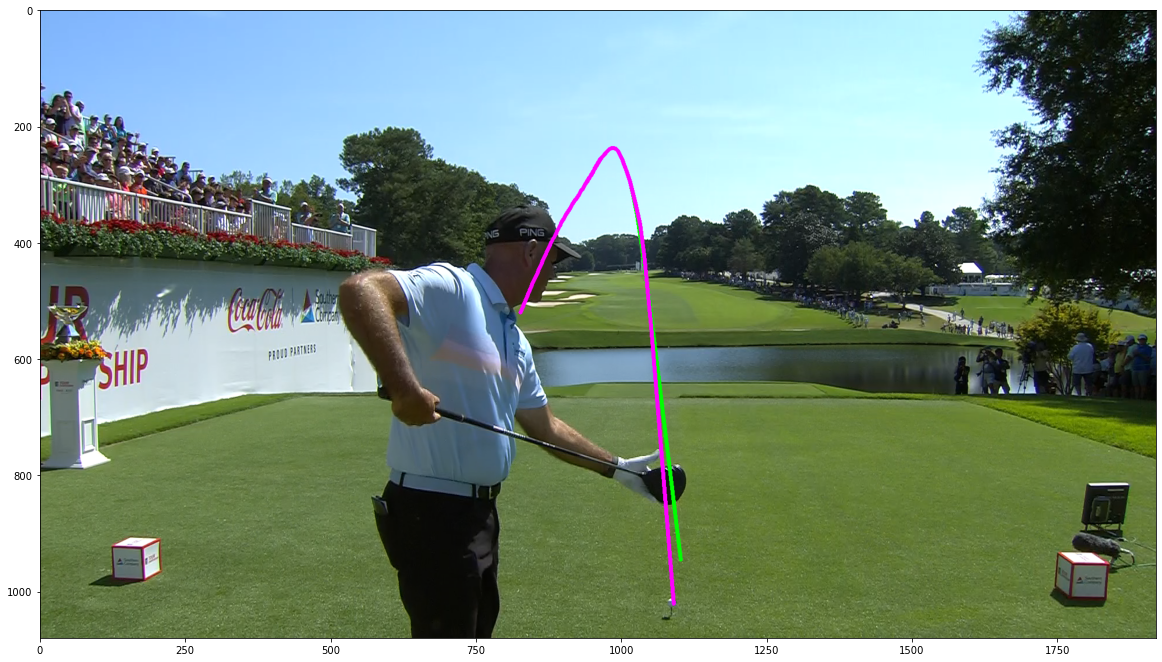

[0.10344132035970688, 0.2830307185649872]


In [13]:
# fit_time = in_time[idx:]
# fit_pos = xyz[idx:,:]
# print(fit_pos)
# [ 2.28717324 -7.11437001 40.2434477 ]
# first fitting point: [2.33064454826695, -6.968391820409611, 40.283069393234854]
# [2.3306445482669504, -6.968391820409611, 40.28306939323486]
# fusion = np.vstack((xyz[:-1,:],fit_pos))

cam_f=np.array([1580.8590649, 1580.8590649])
cam_c=[925.2106820540487, 575.8055319374084]
cam_dis=[0.0, 0.0, 0.0, 0.0]

cam_K = np.array([[cam_f[0], 0, cam_c[0]],[0, cam_f[1], cam_c[1]],[0, 0, 1]])
cam_K_distortion = np.array(cam_dis)
zero = np.array([0.0, 0.0, 0.0])

point_cam_xyz_cv = fusion#np.array(data["xyz_ccs"])

point_cam_uv = cv.projectPoints(point_cam_xyz_cv.reshape(-1, 3), zero, zero, cam_K, cam_K_distortion)[0]
poly_points = point_cam_uv.reshape((-1, 1, 2)).astype(np.int)
print(poly_points.shape)
if True:
    image = cv.polylines(img.copy(), [poly_points], isClosed=False, color=(255, 0, 255), thickness=6)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.show()
print(uv_dist)